In [1]:
from Tranmodel import Tranmodel
import sys
sys.path.insert(1,'../data_utils') 
from SequencesDataset import SequencesDataset

import torch
from einops import rearrange

In [2]:
#sample = torch.rand(2600, 5, 1600)
ds = SequencesDataset(chroms=['chr1'])

Loading sequencing data
Sequencing data loading complete


In [3]:
frontend = Tranmodel.get_pretrained_model(allow_further_training=True)
frontend.requires_grad_(False);

In [4]:
try:
    frontend.cuda()
except:
    pass
sample = ds.fetch([('chr1',522_000,1_300_000),('chr1',522_000,1_300_000)]).to(frontend.device)

In [25]:
import pandas as pd 
coord_info = pd.read_hdf(
            '../../data/processed_data.hdf5',#self.filepath,
            key='coord_info'
        )

In [46]:
from ConfigDataset import ConfigDataset
cds = ConfigDataset('../../data/processed_data.hdf5',segment_length=65) 

In [47]:
cds.start_indices

array([     62,     126,     190, ..., 6390158, 6390222, 6390286])

In [48]:
import numpy as np

start_idx = cds.genomic_index[cds.start_indices]
#np.empty(len(start_idx))

In [49]:
len(cds.start_indices)

96924

In [50]:
cds.start_indices.max()

6390286

In [57]:
regions = cds.get_genomic_regions().copy()
print(len(regions))
regions = regions.sort_values(by=['Chromosome','Start'],axis=0,ignore_index=True)
print(len(regions))

46273
46273


In [68]:
regions['Stop']-= regions['Start']
regions

,Chromosome,Start,Stop
0,1,1260000,1300000
1,1,1340000,1300000
2,1,1360000,1300000
3,1,1400000,1300000
4,1,1420000,1300000
...,...,...,...
46268,X,153840000,1300000
46269,X,153860000,1300000
46270,X,153880000,1300000
46271,X,153940000,1300000


In [64]:
frontend.cpu();

In [5]:
out = frontend(sample)

In [6]:
(out[0,...] == out[1,...]).all()

tensor(False, device='cuda:0')

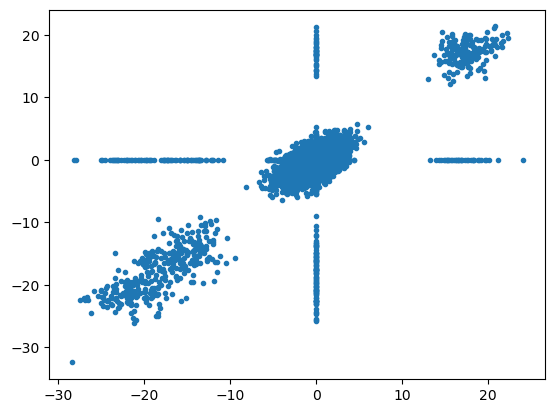

In [7]:
import matplotlib.pyplot as plt

plt.plot(out[0,...].flatten().cpu().numpy(),out[1,...].flatten().cpu().numpy(),'.')

In [8]:
out2 = frontend(sample) 

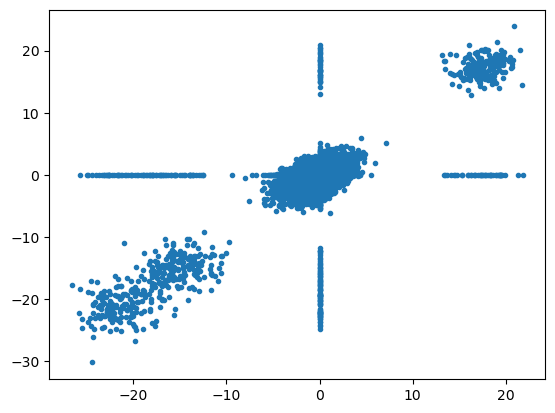

In [9]:
plt.plot(out2[0,...].flatten().cpu().numpy(),out2[1,...].flatten().cpu().numpy(),'.')

In [10]:
(out == out2).all() 

tensor(False, device='cuda:0')

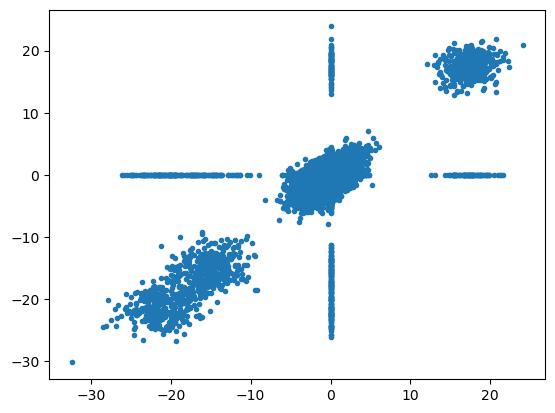

In [11]:
plt.plot(out.flatten().cpu().numpy(),out2.flatten().cpu().numpy(),'.')

In [12]:
frontend.eval();

In [13]:
out = frontend(sample)

In [14]:
(out[0,...] == out[1,...]).all()

tensor(True, device='cuda:0')

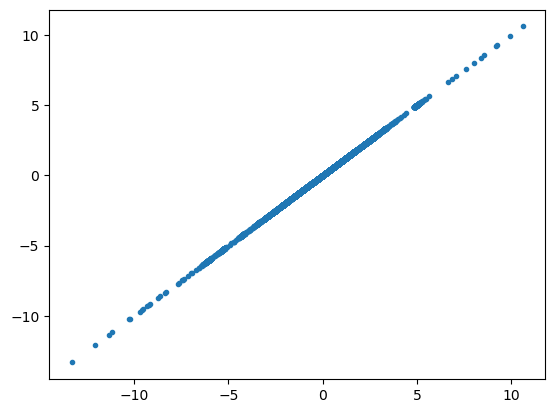

In [15]:
import matplotlib.pyplot as plt

plt.plot(out[0,...].flatten().cpu().numpy(),out[1,...].flatten().cpu().numpy(),'.')

In [16]:
out2 = frontend(sample) 

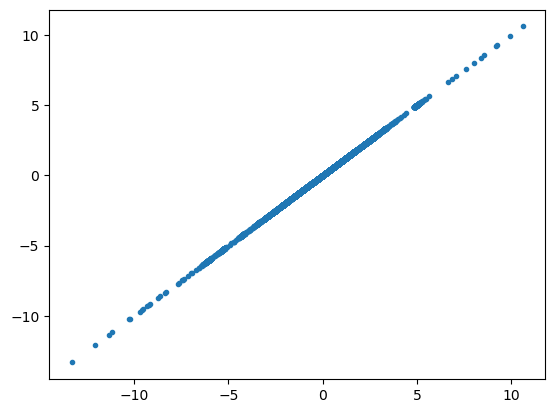

In [17]:
plt.plot(out2[0,...].flatten().cpu().numpy(),out2[1,...].flatten().cpu().numpy(),'.')

In [18]:
(out == out2).all() 

tensor(True, device='cuda:0')

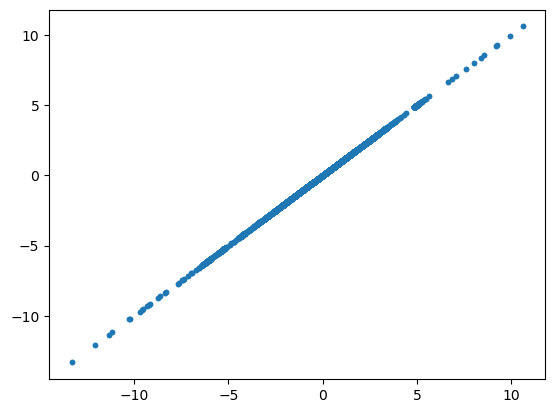

In [19]:
plt.plot(out.flatten().cpu().numpy(),out2.flatten().cpu().numpy(),'.')

In [20]:
z_emb = torch.load('/home/gridsan/gschuette/binz_group_shared/zlao/for_greg/run_scripts_1/chr_1_522.pt',map_location='cpu')

In [21]:
z_emb.requires_grad_(False); 

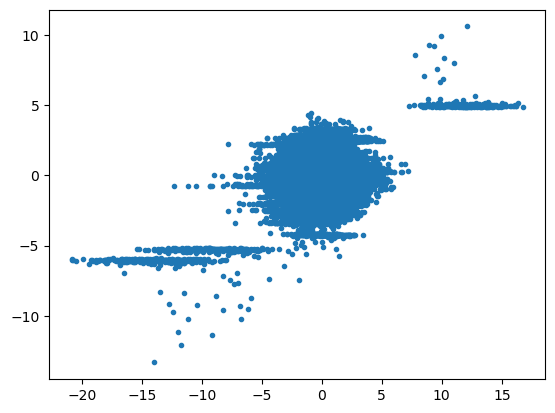

In [22]:
plt.plot(z_emb.flatten().cpu().numpy(),out[0,...].flatten().cpu().numpy(),'.')

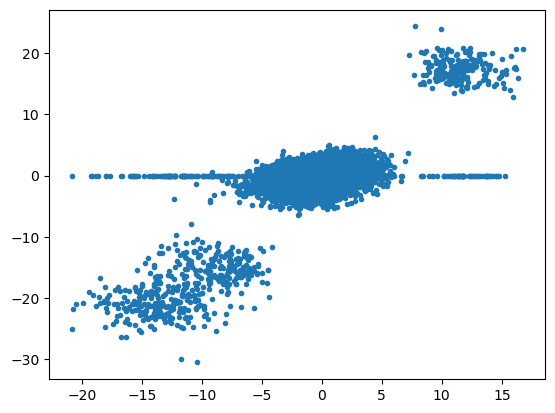

In [23]:
try: 
    frontend = Tranmodel.get_pretrained_model(allow_further_training=True).cuda()
except: 
    frontend = Tranmodel.get_pretrained_model(allow_further_training=True)
frontend.requires_grad_(False) 
out = frontend(sample)
plt.plot(z_emb.flatten().cpu().numpy(),out[0,...].flatten().cpu().numpy(),'.')

In [4]:
frontend = Tranmodel.get_pretrained_model(allow_further_training=False).cuda()

In [5]:
import time
batch_sizes = [1,2,4,8,16,32,64,128]
ntrials = 10
times = torch.zeros(len(batch_sizes),ntrials,dtype=torch.double)

for i,bs in enumerate(batch_sizes): 
    for t in range(ntrials):
        times[i,t]-= time.time()
        batch = ds.fetch([('chr1',522_000,1_300_000) for _ in range(bs)]).to(frontend.device)
        temp = frontend(batch) 
        times[i,t]+= time.time()
        del temp

OutOfMemoryError: CUDA out of memory. Tried to allocate 15.69 GiB (GPU 0; 31.74 GiB total capacity; 16.13 GiB already allocated; 14.19 GiB free; 17.17 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [36]:
batch_sizes = [1,2,4,8,16,32,64,128]
ntrials = 10 

ts = torch.zeros(len(batch_sizes), ntrials,dtype=torch.double) 
for i,bs in enumerate(batch_sizes): 
    idxs = [('chr1',522_000,1_300_000) for _ in range(bs)]
    for t in range(ntrials):
        ts[i,t]-= time.time()
        batch = ds.fetch(idxs).to(frontend.device)
        ts[i,t]+= time.time()

In [37]:
ts1 = ts / torch.tensor(batch_sizes)[:,None]
ts1.mean()

tensor(0.0101, dtype=torch.float64)

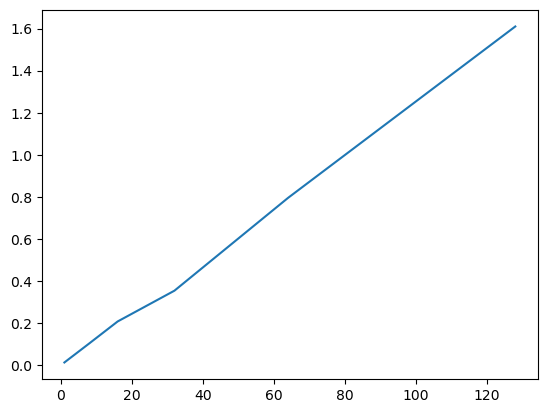

In [16]:
import matplotlib.pyplot as plt
tt = ts.mean(-1) 
plt.plot(batch_sizes,tt) 

In [30]:
import os
import numpy as np
import torch
import pandas as pd
from scipy.sparse import load_npz

##########
# Load functions for the genome. Adapted from what Zhuohan sent me 
def pad_seq_matrix(matrix, pad_len=300):
    paddings = np.zeros((1, 4, pad_len)).astype('int8')
    dmatrix = np.concatenate((paddings, matrix[:, :, -pad_len:]), axis=0)[:-1, :, :]
    umatrix = np.concatenate((matrix[:, :, :pad_len], paddings), axis=0)[1:, :, :]
    return np.concatenate((dmatrix, matrix, umatrix), axis=2)
    
def load_ref_genome(fp):
    #try:
    #    ref_gen_data = load_npz(fp).toarray().reshape(4, -1, 1000).swapaxes(0, 1)
    #except:
    #    print(fp) 
    #    return []
    ref_gen_data = load_npz(fp).toarray().reshape(4, -1, 1000).swapaxes(0, 1)
    return torch.tensor(pad_seq_matrix(ref_gen_data))

##########
# Load functions for DNase data. Adapted from what Zhuohan sent me 
def pad_signal_matrix(matrix, pad_len=300):
    paddings = np.zeros(pad_len).astype('float32')
    dmatrix = np.vstack((paddings, matrix[:, -pad_len:]))[:-1, :]
    umatrix = np.vstack((matrix[:, :pad_len], paddings))[1:, :]
    return np.hstack((dmatrix, matrix, umatrix))
    
def load_dnase(fp,chroms):
    chroms_ = [int(chrom[3:]) if chrom[3:].isnumeric() else chrom[3:] for chrom in chroms]
    dnase_seq_ = pd.read_pickle(fp)
    dnase_seq = {}
    for chrom in chroms: 
        chr = int(chrom[3:]) if chrom[3:].isnumeric() else chrom[3:]
        dnase_seq[chrom] = dnase_seq_[chr]
    del dnase_seq_
    
    for chr in dnase_seq: 
        dnase_seq[chr] = torch.tensor(np.expand_dims(pad_signal_matrix(dnase_seq[chr].toarray().reshape(-1, 1000)), axis=1))

    return dnase_seq

##########
# Class by Greg
class SequencesDataset:

    def __init__(
        self,
        cell_type = 'GM12878',
        alignment = 'hg19',
        data_dir = '../../data/',
        resolution=20_000,
        region_length=1_300_000,
        batch_size=64,
        chroms = None
    ):
        self.dnase_fp = data_dir + f'outside/{cell_type}_{alignment}.pkl' 
        self.res = resolution // 1000
        self.length = region_length // 1000
        self.batch_size = batch_size

        if chroms is None: 
            chroms = [f'chr{k}' for k in [*range(1,23),'X']]
        elif type(chroms) == str:
            chroms = [chroms] 
        elif type(chroms) == int: 
            chroms = [f'chr{chroms}']
        '''
        else: 
            raise Exception('More work for greg to do here for generalization')
            # Probably use an external function to do the two elif statements & iterate through them here
        '''
        self.chroms = chroms
        
        # Ensure all files exist 
        self.genome_fps = {}
        for chrom in chroms: 
            self.genome_fps[chrom] = data_dir + f'outside/{alignment}/{chrom}.npz'
            assert os.path.exists(self.genome_fps[chrom]), self.genome_fps[chrom]

        assert os.path.exists(self.dnase_fp), self.dnase_fp

        # Load the data
        print(f'Loading sequencing data')
        self.load_genome()
        self.load_dnase()
        print(f'Sequencing data loading complete')

        # Prepare to iterate
        self.curr_chrom = 0
        self.curr_idx = 0 
        self.inner_idx = 0 

        self.data = {}
        for c in self.genome:
            self.data[c] = torch.cat((self.genome[c],self.dnase[c]),dim=-2)

    ##################################################
    # Loading functions
    def load_genome(self):
        self.genome = {}
        for chrom,fp in self.genome_fps.items():
            self.genome[chrom] = load_ref_genome(fp)

    def load_dnase(self):
        self.dnase = load_dnase(self.dnase_fp,self.chroms)

    ##################################################
    # Data loading functions 
    def _update_sample_idx_(self):
        
        self.curr_idx+= self.res

        c = self.chroms[self.curr_chrom]
        if self.curr_idx + self.length >= seq_ds.genome[c].shape[0]:
            self.curr_idx = 0
            self.curr_chrom = (self.curr_chrom+1) % len(self.chroms)

    def _get_sample_(self,idx=None):
        if idx is None:
            c,i,l = self.chroms[self.curr_chrom],self.curr_idx,self.length
        else:
            c,i,l = idx # uses kb resolution for i,l (see self.fetch for comparison) 

        return self.data[c][i:i+l,...] 
        
        '''
        ref_seq = self.genome[c][i:i+l,...]
        dnase_seq = self.dnase[c][i:i+l,...]

        return ref_seq, dnase_seq 
        '''
        
    def _region_is_valid_(self):

        ref_seq, dnase_seq = self._get_sample_()

        return ~(ref_seq==0).all(1).any(), ref_seq, dnase_seq
        
    def __iter__(self):
        self.curr_chrom = 0
        self.curr_idx = 0
        self.inner_idx = 0
        return self
    
    def __next__(self):

        if (self.curr_chrom == 0) and (self.curr_idx == 0) and self.inner_idx > 0:
            self.inner_idx == 0 
            raise StopIteration # Back to the start!

        batch_ref_seq = []
        batch_dnase_seq = []
        while len(batch_ref_seq) < self.batch_size:

            is_valid, ref_seq, dnase_seq = self._region_is_valid_()
            if is_valid:
                batch_ref_seq.append(ref_seq)
                batch_dnase_seq.append(dnase_seq)
                self.inner_idx+= 1

            self._update_sample_idx_()

            if (self.curr_chrom == 0) and (self.curr_idx == 0):
                # Went back to the start. This epoch is over! 
                break

        if len(batch_ref_seq) == 0:
            # We must have broken out of the while loop before finding any valid samples
            self.inner_idx == 0 
            raise StopIteration

        # Stack the subobjects as desired.
        batch_ref_seq = torch.stack(batch_ref_seq,dim=0) 
        batch_dnase_seq = torch.stack(batch_dnase_seq,dim=0) 
        
        return batch_ref_seq, batch_dnase_seq

    # For easier interfacing with my other classes. 
    def _fetch_one_(self,idx):
        '''
        idx = tuple(chrom,start_idx (in bp), region length (in bp))
        '''
        c,s,l = idx

        assert s%1000 == 0 
        s//= 1000
        assert l%1000 == 0
        l//= 1000
        if c not in self.chroms:
            c = f'chr{c}'
        assert c in self.chroms

        return self._get_sample_(idx=(c,s,l))
        
    def is_valid(self,idx):
        '''
        idx = same as described in self._fetch_one_
        '''
        ref_seq, dnase_seq = self._fetch_one_(idx)
        
        return ~(ref_seq==0).all(1).any(), ref_seq, dnase_seq
    
    def fetch(self,idxs):
        '''
        idxs is a list of tuples with the shape desribed for idx in the self._fetch_one_ function above.
        '''

        seqs = []
        for idx in idxs: 
            seqs.append(self._fetch_one_(idx))#torch.cat(self._fetch_one_(idx),dim=-2))

        return torch.stack(seqs,dim=0) 
            
        
        '''
        ref_seqs = []
        dnase_seqs = []
        idxs_return = []
        for idx in idxs: 
            is_valid, ref_seq, dnase_seq = self.is_valid(idx) 
            if return_invalid or is_valid: 
                idxs_return.append(idx)
                ref_seqs.append(ref_seq)
                dnase_seqs.append(dnase_seq)

        ref_seqs = torch.stack(ref_seqs,dim=0)
        dnase_seqs = torch.stack(dnase_seqs,dim=0) 

        return idxs_return, ref_seqs, dnase_seqs
        '''


In [31]:
ds2 = SequencesDataset(chroms=['chr1'])

Loading sequencing data
Sequencing data loading complete


In [38]:
batch_sizes = [1,2,4,8,16,32,64,128]
ntrials = 10 

ts2 = torch.zeros(len(batch_sizes), ntrials,dtype=torch.double) 
for i,bs in enumerate(batch_sizes): 
    idxs = [('chr1',522_000,1_300_000) for _ in range(bs)]
    for t in range(ntrials):
        ts2[i,t]-= time.time()
        batch = ds2.fetch(idxs).to(frontend.device)
        ts2[i,t]+= time.time()

In [39]:
ts21 = ts2 / torch.tensor(batch_sizes)[:,None]
ts21.mean()

tensor(0.0107, dtype=torch.float64)

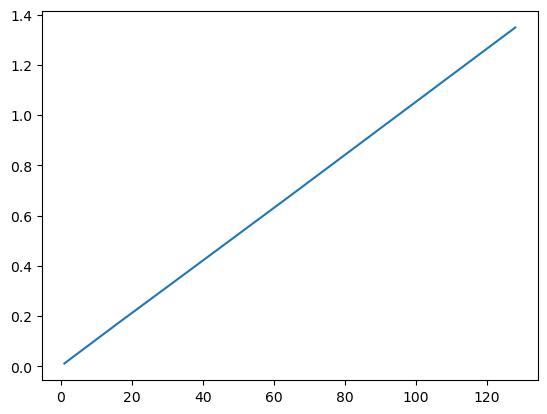

In [40]:
import matplotlib.pyplot as plt
tt = ts2.mean(-1) 
plt.plot(batch_sizes,tt) 

In [42]:
batch_sizes = [1,2,4,8,16,32,64,128]
ntrials = 10 

ts2 = torch.zeros(len(batch_sizes), ntrials,dtype=torch.double) 
for i,bs in enumerate(batch_sizes): 
    batch = ds2.fetch([('chr1',522_000,1_300_000) for _ in range(bs)]).to(frontend.device)
    for t in range(ntrials):
        ts2[i,t]-= time.time()
        sample = frontend(batch)
        ts2[i,t]+= time.time()
        del sample 

OutOfMemoryError: CUDA out of memory. Tried to allocate 15.69 GiB (GPU 0; 31.74 GiB total capacity; 16.13 GiB already allocated; 14.19 GiB free; 17.17 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

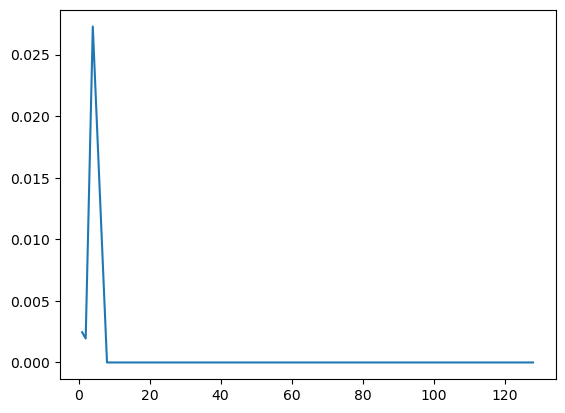

In [57]:
import matplotlib.pyplot as plt
tt = ts2.mean(-1) 
tt[tt<0] = 0 
plt.plot(batch_sizes,tt.numpy()) 

In [69]:
del temp 

In [70]:
t = -time.time()
frontend(batch[:3,...])
t+= time.time()

OutOfMemoryError: CUDA out of memory. Tried to allocate 5.92 GiB (GPU 0; 31.74 GiB total capacity; 30.21 GiB already allocated; 666.88 MiB free; 30.71 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [68]:
t

-1704230604.9090598

In [74]:
chrom='X'
a = regions[regions['Chromosome'] == chrom].reset_index(drop=True) 

In [79]:
a['data'] = ''
a

,Chromosome,Start,Stop,data
0,X,300000,1300000,
1,X,380000,1300000,
2,X,460000,1300000,
3,X,500000,1300000,
4,X,540000,1300000,
...,...,...,...,...
2813,X,153840000,1300000,
2814,X,153860000,1300000,
2815,X,153880000,1300000,
2816,X,153940000,1300000,


In [76]:
regions

,Chromosome,Start,Stop
0,1,1260000,1300000
1,1,1340000,1300000
2,1,1360000,1300000
3,1,1400000,1300000
4,1,1420000,1300000
...,...,...,...
46268,X,153840000,1300000
46269,X,153860000,1300000
46270,X,153880000,1300000
46271,X,153940000,1300000


In [80]:
a

,Chromosome,Start,Stop,data
0,X,300000,1300000,
1,X,380000,1300000,
2,X,460000,1300000,
3,X,500000,1300000,
4,X,540000,1300000,
...,...,...,...,...
2813,X,153840000,1300000,
2814,X,153860000,1300000,
2815,X,153880000,1300000,
2816,X,153940000,1300000,


In [84]:
regions = cds.get_genomic_regions()
regions = regions.rename(
    columns={
        'Chromosome':'Chromosome',
        'Start':'Genomic_Index',
        'Stop':'Region_Length'
    }
)
regions['Region_Length']-= regions['Genomic_Index']

In [91]:
chrom = 1#'X'
embed_df = regions[regions['Chromosome'] == str(chrom)].reset_index(drop=True)

In [92]:
i = 0 
chr = f'chr{chrom}'
raw = ds.fetch([ (chr,embed_df.loc[i,'Genomic_Index'],embed_df.loc[i,'Region_Length']) ])

In [94]:
raw.shape

torch.Size([1, 1300, 5, 1600])

In [98]:
a = (raw[:,:,:-1,:]==1).any(-2)
a.sum() / a.numel()

tensor(0.8931)

In [100]:
import os
save_folder = '../../data/embeddings/'
dest_fp = lambda chrom: save_folder+f'chrom_{chrom}.tar.gz'#'../../data/processed_data.hdf5'
if not os.path.exists(save_folder): 
    os.mkdir(save_folder)

In [4]:
a = [1,2,3,4]
[
    k for k in a if k!=2
]

[1, 3, 4]

In [2]:
import numpy as np
import pandas as pd
idx_to_keep = np.ones(10,dtype=bool) 
idx_to_keep[5] = False

In [8]:
df = pd.DataFrame()
df['col1'] = np.arange(10)
df['col2'] = np.arange(10)
df['col3'] = np.arange(10)

df[idx_to_keep] 

,col1,col2,col3
0,0,0,0
1,1,1,1
2,2,2,2
3,3,3,3
4,4,4,4
6,6,6,6
7,7,7,7
8,8,8,8
9,9,9,9


In [6]:
for k in reversed([*range(1,23),'X']): 
    print(k) 

X
22
21
20
19
18
17
16
15
14
13
12
11
10
9
8
7
6
5
4
3
2
1


In [7]:
['X',*reversed(range(1,23))]

['X',
 22,
 21,
 20,
 19,
 18,
 17,
 16,
 15,
 14,
 13,
 12,
 11,
 10,
 9,
 8,
 7,
 6,
 5,
 4,
 3,
 2,
 1]

In [2]:
import sys
sys.path.insert(1,'../frontend/')
from Tranmodel import Tranmodel

In [4]:
model = Tranmodel.get_pretrained_model(allow_further_training=True)

In [10]:
for k in dir(model):
    if 'grad' in k:
        print(k)

requires_grad_
zero_grad


In [11]:
pwd

'/home/gridsan/gschuette/refining_scHiC/revamp_with_zhuohan/code/frontend'

In [1]:
cd ../data_utils/

/home/gridsan/gschuette/refining_scHiC/revamp_with_zhuohan/code/data_utils


In [2]:
from ConfigDataset import ConfigDataset

cds = ConfigDataset(
    '~/binz_group_shared/gkks/with_Zhuohan/processed_data.hdf5', # Or whatever the filepath ends up being. 
    segment_length=65,         # This is the number of monomers. For the dataset used so far, each bead represents 20kb. 
    batch_size=1,              # You can adjust this if you want to use the data for training, but this won't be relevant for what I'm showing here. 
    normalize_distances=False, # Important because I didn't give you the files this calls. Normalizing the distances is really only important for the diffusion model anyway.
    cell_numbers=None,         # ALL cells are loaded if this is set to None. If you only want specific cells (the 1-17 options), set cell_numbers=[1,2,... whatever is desired]
    chroms=['1'],               # ALL chromosomes are loaded if this is set to None. If you only want specific chromosomes, set chroms=['1','2',... whatever is desired]
    replicates=None,           # ALL replicates are loaded if this is set to None. If you only want specific replicates to load, set replicates=[0,1,2] (or whatever your desired subset is) 
    shuffle=False,             # Again, modify this if you want to train
    allow_overlap=True,        # This determines whether the configurations provided by the class are allowed to overlap. Set to False if you want fully independent regions
)

In [3]:
info, coords = cds.fetch_specific_coords(
    chrom=1, 
    start_idx=1420000
)

0
10763
21562
97341
108312
119273
195368
206057
227400
238254
249129
260011
271009
282004
292982
303830
314664
325521
336259
347060
357921
368938
379915
390890
401811
412729
423670
434524
445344
456187
467227
478263


In [10]:
gr = cds.get_genomic_regions()

In [14]:
chrom,start,stop = gr.loc[0].values

In [17]:
start

780000

In [5]:
import numpy as np

start_idx=1420000
cell=1
chrom='1'
replicate=0

inner_min = cds.coord_info[
    (cds.coord_info.Cell == cell) & 
    (cds.coord_info.Chromosome == chrom) &
    (cds.coord_info.Replicate == replicate)
]

inner_min, inner_max = int(inner_min.idx_min.values), int(inner_min.idx_max.values)

temp_gen_idx = cds.genomic_index[inner_min:inner_max]

start = np.where(
    temp_gen_idx == start_idx
)[0] + inner_min




In [6]:
start

array([0])

In [4]:
cds.coord_info

,Accession,Organism,Cell_Type,Cell,Replicate,Chromosome,idx_min,idx_max
0,GSE117876,Human,GM12878,1,0,1,0,10760
1,GSE117876,Human,GM12878,1,1,1,10761,21560
2,GSE117876,Human,GM12878,1,2,1,21561,32290
3,GSE117876,Human,GM12878,2,0,1,32291,43172
4,GSE117876,Human,GM12878,2,1,1,43173,54070
5,GSE117876,Human,GM12878,2,2,1,54071,64983
6,GSE117876,Human,GM12878,3,0,1,64984,75760
7,GSE117876,Human,GM12878,3,1,1,75761,86554
8,GSE117876,Human,GM12878,3,2,1,86555,97329
9,GSE117876,Human,GM12878,5,0,1,97330,108298


In [10]:
cds.start_indices

489197

In [26]:
gr = cds.get_genomic_regions()

In [29]:
gr.Chromosome.unique()

array(['1'], dtype=object)

In [30]:
cds.genomic_index

array([  1420000,   1440000,   1460000, ..., 248960000, 248980000,
       249000000])

In [24]:
cds.coord_info.Cell.unique()

array([ 1,  2,  3,  5,  6,  7,  9, 10, 11, 12, 13, 14, 15, 16, 17])

In [31]:
import numpy as np
a = np.arange(10)
np.where(
    (a == 5) & 
    (a == 5)
)

(array([5]),)

In [35]:
np.where(cds.genomic_index == 1420000)[0]

array([     0,  10763,  21562,  32296,  43177,  54081,  97341, 108312,
       119273, 163112, 173871, 184624, 195368, 206057, 227400, 238254,
       249129, 260011, 271009, 282004, 292982, 303830, 314664, 325521,
       336259, 347060, 357921, 368938, 379915, 390890, 401811, 412729,
       423670, 434524, 445344, 456187, 467227, 478263])

In [42]:
chrom='1'
replicate = 0 
cell = 1

int(cds.coord_info[
    (cds.coord_info.Cell == cell) & 
    (cds.coord_info.Chromosome == chrom) &
    (cds.coord_info.Replicate == replicate)
].idx_max.values)

10760

In [45]:
cds.genomic_index[0:10760]

10760

In [47]:
cds.coords.shape

torch.Size([489262, 6])

In [1]:
from cooler import Cooler 

In [34]:
clr = Cooler('../../data/outside/GM12878_hg38.mcool::/resolutions/1000')

In [28]:
clr = Cooler('../../data/outside/GM12878_hg19_1000.cool')

In [31]:
clr.info['bin-size']

1000

In [38]:
import cooler

In [41]:
fp = '../../data/outside/GM12878_hg38.mcool'
resolutions = [int(c.split('/')[-1]) for c in cooler.fileops.list_coolers(fp)]


In [46]:
cooler.fileops.is_multires_file('./zhuohan.ipynb')

False

In [47]:
cooler.fileops.list_coolers(fp)

['/resolutions/1000',
 '/resolutions/2000',
 '/resolutions/5000',
 '/resolutions/10000',
 '/resolutions/25000',
 '/resolutions/50000',
 '/resolutions/100000',
 '/resolutions/250000',
 '/resolutions/500000',
 '/resolutions/1000000',
 '/resolutions/2500000',
 '/resolutions/5000000',
 '/resolutions/10000000']